# Face Analysis with Supervised and Unsupervised Neural Networks

In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.io
import matplotlib.pyplot as plt
import datetime
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans

import tensorflow as tf

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


# Data Preparation

We'll load in the data, examine what we've got, etc...

## Load the Data

The metadata is in a .mat file, so we'll have some funky formatting to take care of.

In [2]:
# In case you've already saved variables and want to skip all the processing.
df_all = pd.read_pickle('df_all.pkl')

In [7]:
# Convert the metadata MAT file. Due to unweildy formatting, this is easiest by to do by hand.
data_path = '/data/'

# Load the MAT
dat_wiki = scipy.io.loadmat(data_path + 'wiki_crop/wiki.mat')
dat_imdb = scipy.io.loadmat(data_path + 'imdb_crop/imdb.mat')

# For reference, data => dat_wiki, data_path => '/data/wiki_crop', name_str => 'wiki'

def make_df(data, data_path, name_str):
    
    # Create the dataframe. Indices are the sum of the lengths of the two data sources.
    df = pd.DataFrame(index=range(len(data[name_str][0][0][1][0])), 
        columns=['dob', 'photo_yr', 'age', 'file_path', 'gender', 
                           'name', 'face_loc', 'face_score', 'second_face'],
        data=0)

    # Load in individual rows. DOB Comes in ordinal format.
    df.dob = [datetime.date.fromordinal(x).year for x in data[name_str][0][0][0][0]]
    df.photo_yr = data[name_str][0][0][1][0]
    df.age = df.photo_yr - df.dob
    df.file_path = [data_path + x[0] for x in data[name_str][0][0][2][0]]
    df.gender = data[name_str][0][0][3][0]
    df.name = data[name_str][0][0][4][0]
    df.face_loc = [x[0] for x in data[name_str][0][0][5][0]]
    df.face_score = data[name_str][0][0][6][0]
    df.second_face = data[name_str][0][0][7][0]
    
    return df

# Merge and display results.
df_wiki = make_df(dat_wiki, '/data/wiki_crop/', 'wiki')
df_imdb = make_df(dat_imdb, '/data/imdb_crop/', 'imdb')
df_all = pd.concat([df_wiki, df_imdb]).reset_index(drop=True)

df_all.head()

dob  photo_yr  age                                        file_path  \
0  1982      2009   27  /data/wiki_crop/17/10000217_1981-05-05_2009.jpg   
1  1926      1964   38  /data/wiki_crop/48/10000548_1925-04-04_1964.jpg   
2  1949      2008   59    /data/wiki_crop/12/100012_1948-07-03_2008.jpg   
3  1931      1961   30  /data/wiki_crop/65/10001965_1930-05-23_1961.jpg   
4  1972      2012   40  /data/wiki_crop/16/10002116_1971-05-31_2012.jpg   

   gender                    name  \
0     1.0       [Sami Jauhojärvi]   
1     1.0        [Dettmar Cramer]   
2     1.0           [Marc Okrand]   
3     1.0  [Aleksandar Matanović]   
4     0.0          [Diana Damrau]   

                                            face_loc  face_score  second_face  
0  [111.291094733, 111.291094733, 252.669930818, ...    4.300962          NaN  
1  [252.483302295, 126.681651148, 354.531925962, ...    2.645639     1.949248  
2                    [113.52, 169.84, 366.08, 422.4]    4.329329          NaN  
3                                   [1, 1, 634, 440]        -inf          NaN  
4  [171.610314052, 75.5745123976, 266.766115706, ...    3.408442          NaN

## Examine the Data

Let's see what we've got!

In [8]:
# Any missing data?
df_all.isnull().sum()

dob                 0
photo_yr            0
age                 0
file_path           0
gender          11105
name                0
face_loc            0
face_score          0
second_face    305158
dtype: int64

That's a good starting point. At some point later on we may need to exclude the NaN gender results, but that should be fine for predicting Age. The 'second_face' feature is interesting. Per the documentation, NaN values are when no second face is present. Having two faces in an image could cause some problems, so I'm tempted to use only those examples that have NO second face.

In [9]:
# Drop all examples where 'second_face' is not null.
df_all = df_all.drop(df_all[~df_all.second_face.isnull()].index).reset_index(drop=True)
print(df_all.shape)

(305158, 9)


Because we're using the pre-cropped images, we won't have to worry about 'face_loc', which gives coordinates for where the face is in the image. We are interested in 'face_score', however, as it tells us how easily identifiable the face was in the image. Let's look at a few different values and see if we should remove images below some threshold.

In [10]:
df_all.face_score.describe()

count    3.051580e+05
mean             -inf
std               NaN
min              -inf
25%              -inf
50%      2.332299e+00
75%      3.774737e+00
max      7.381689e+00
Name: face_score, dtype: float64

Values of '-inf' have no face present. Let's look at some of those, plus some with values near 0.8, 1.5, and 3.0. There are no face values below 0.7 except the -inf values, so the 0.8 group will be examples of the 'worst' face identification.

In [11]:
# Grab file names fitting each face_score range.
files_no_face = df_all[df_all.face_score < 0].sample(3, random_state=99).file_path
files_low_face = df_all[(df_all.face_score > 0) & (df_all.face_score < 0.8)].sample(3, random_state=99).file_path
files_med_face = df_all[(df_all.face_score > 1.4) & (df_all.face_score < 1.6)].sample(3, random_state=99).file_path
files_high_face = df_all[(df_all.face_score > 2.9) & (df_all.face_score < 3.1)].sample(3, random_state=99).file_path

# Use cv2 to grab the images.
im_no_face = [cv2.imread(x) for x in files_no_face]
im_low_face = [cv2.imread(x) for x in files_low_face]
im_med_face = [cv2.imread(x) for x in files_med_face]
im_high_face = [cv2.imread(x) for x in files_high_face]

In [3]:
def plot_three(im_list):
    plt.figure(figsize=(14,4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i+1)
        plt.imshow(array[:,:,::-1])
    plt.show()
    
def plot_nine(im_list):
    plt.figure(figsize=(14,14))
    for i, array in enumerate(im_list):
        plt.subplot(3, 3, i+1)
        plt.imshow(array[:,:,::-1])
    plt.show()

face_score of -inf:


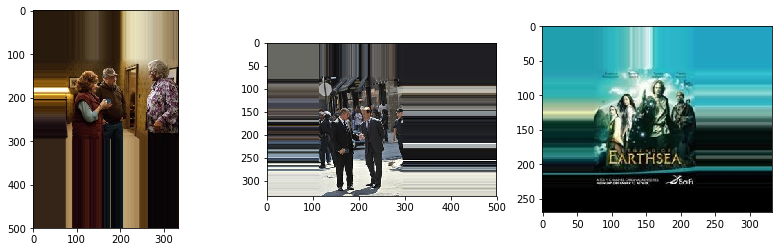

In [12]:
# Let's see the images with -inf face_score.
print('face_score of -inf:')
plot_three(im_no_face)

Yup -- none of those have faces. We'll have to remove all of them.

face_score below 0.8:


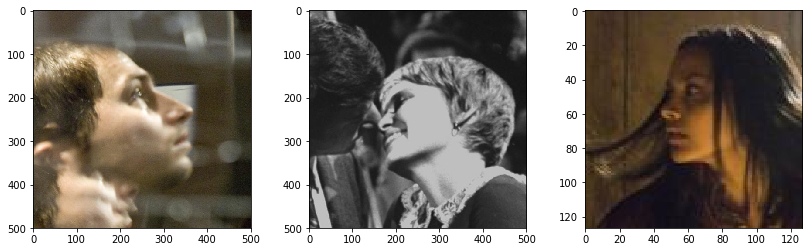

face_score near 1.5:


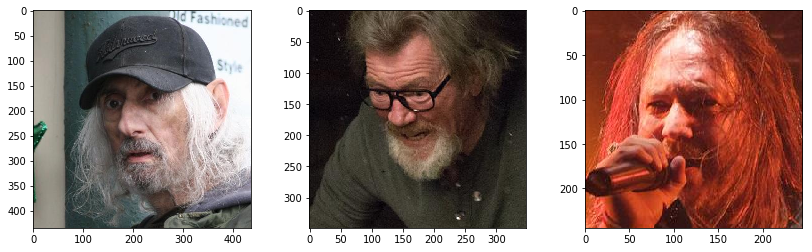

face_score near 3.0:


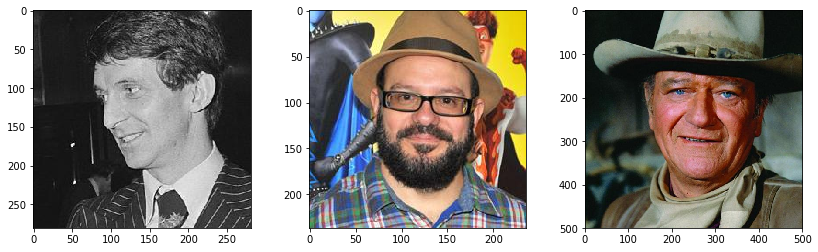

In [13]:
# Now the rest
print('face_score below 0.8:')
plot_three(im_low_face)
print('face_score near 1.5:')
plot_three(im_med_face)
print('face_score near 3.0:')
plot_three(im_high_face)

All those seem fine. We can include all the examples except those with '-inf' face_score.

In [14]:
# Drop elements with negative face_score.
df_all = df_all.drop(df_all[df_all.face_score<0].index).reset_index(drop=True)
print(df_all.shape)

(224840, 9)


Well, we've had to eliminate a large portion of our dataset, but those images were not going to help with our model. Since we're curious about age, let's take a look at its distribution.

In [15]:
print(df_all.age.describe())
print('Below 15:', df_all[df_all.age < 15].shape[0])
print('Above 65:', df_all[df_all.age > 65].shape[0])

count    224840.000000
mean         36.742742
std          34.323033
min         -40.000000
25%          26.000000
50%          34.000000
75%          44.000000
max        2014.000000
Name: age, dtype: float64
Below 15: 5268
Above 65: 8505


Oops -- we've got some bad values in here. We also have too few examples below 15 or over 65. As we'll see, we're going to have to resample the data to balance our age groups, and leaving in age groups with too few examples will cause many duplicates to be made. Let's remove the extreme values.

In [16]:
# Drop age outliers.
print('Age outliers:', len(df_all[(df_all.age <= 15) | (df_all.age > 65)]))
df_all = df_all.drop(df_all[(df_all.age <= 15) | (df_all.age > 65)].index).reset_index(drop=True)
print('New shape:', df_all.shape)

Age outliers: 14991
New shape: (209849, 9)


And the distribution of the remaining ages?

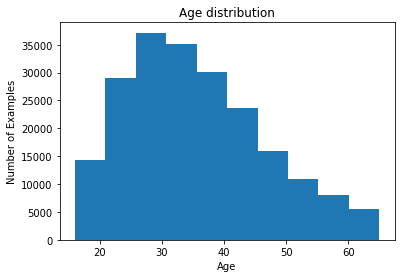

In [17]:
plt.hist(df_all.age, bins=10)
plt.xlabel('Age')
plt.ylabel('Number of Examples')
plt.title('Age distribution')
plt.show()

We'll have to resample the data to balance the ages, but we'll only do it on the training set, after the data is split.

## Drop Small Images

One final step before we split the data: we have to get rid of the small images in our dataset. Some of them are only 1x1 pixel! I hesitate to load in all the images just to get their sizes, but it actually goes pretty quickly, and it will be valuable to have the original dimensions stored in the dataframe. Let's visualize the dimension distribution of our images.

In [4]:
# Function to create x_dim and y_dim features in our df, load each image and populate that data.

def get_x_y_dims(df):

    # Create our new features
    df['x_dim'] = 0
    df['y_dim'] = 0

    # Iterate over the rows to grab the image size.
    for index in df.index:
        image = cv2.imread(df.loc[index, 'file_path'])
        df.loc[index, 'x_dim'] = image.shape[0]
        df.loc[index, 'y_dim'] = image.shape[1]
        
        if index % 5000 == 0:
            print(index)
        
    return df

In [ ]:
df_all = get_x_y_dims(df_all)
print(df_all.columns)

Index(['dob', 'photo_yr', 'age', 'file_path', 'gender', 'name', 'face_loc',
       'face_score', 'second_face', 'x_dim', 'y_dim'],
      dtype='object')


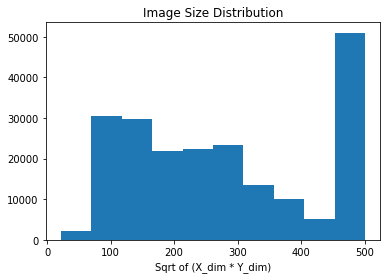

Number of small images: 13992


In [21]:
plt.hist(np.sqrt(np.multiply(df_all.x_dim, df_all.y_dim)))
plt.xlabel('Sqrt of (X_dim * Y_dim)')
plt.title('Image Size Distribution')
plt.show()

print('Number of small images:', df_all[(df_all.x_dim < 90) | (df_all.y_dim < 90)].shape[0])

We have a lot of images right around 200x200 pixels. We want to avoid upsizing too many of our images, but we also want to keep as high resolution as possible (even though that will increase processing time). Only about 3% of our remaining images are below 90x90 pixels, so I'm going to go ahead and drop those images and rescale everything else to 150x150 pixels. This is a judgment call, but it seems like a good balance based on the data we're dealing with. We'll do the actual image resize during the batch process later on.

In [5]:
def drop_small_images(df, dim_size):
    # Drop small images where either dimension is below the threshold.
    df = df.drop(df[(df.x_dim < dim_size) | (df.y_dim < dim_size)].index).reset_index(drop=True)
    return df

In [24]:
#Drop the small images.
df_all = drop_small_images(df_all, 90)

print('New shape:', df_all.shape)

New shape: (195857, 11)


In [29]:
# Let's just save this so we can skip all the processing in the future.
df_all.to_pickle('df_all.pkl')

## Splitting the Data

We'll split our data into training, validation, and test sets. We won't touch the test set until everything is tuned up and finalized. At this point I would like to process and normalize the data, however, those arrays take up too much memory, so we'll do processing in the batch step.

In [6]:
df_all.head()

dob  photo_yr  age                                        file_path  \
0  1982      2009   27  /data/wiki_crop/17/10000217_1981-05-05_2009.jpg   
1  1949      2008   59    /data/wiki_crop/12/100012_1948-07-03_2008.jpg   
2  1972      2012   40  /data/wiki_crop/16/10002116_1971-05-31_2012.jpg   
3  1961      2012   51  /data/wiki_crop/02/10002702_1960-11-09_2012.jpg   
4  1938      1971   33  /data/wiki_crop/41/10003541_1937-09-27_1971.jpg   

   gender                name  \
0     1.0   [Sami Jauhojärvi]   
1     1.0       [Marc Okrand]   
2     0.0      [Diana Damrau]   
3     0.0    [Krista Tippett]   
4     1.0  [Bernie Whitebear]   

                                            face_loc  face_score  second_face  \
0  [111.291094733, 111.291094733, 252.669930818, ...    4.300962          NaN   
1                    [113.52, 169.84, 366.08, 422.4]    4.329329          NaN   
2  [171.610314052, 75.5745123976, 266.766115706, ...    3.408442          NaN   
3  [274.765632403, 57.7700900839, 376.886994554, ...    4.748056          NaN   
4  [79.3558018869, 26.6599339623, 197.609504717, ...    4.184828          NaN   

   x_dim  y_dim  
0    257    257  
1    457    457  
2    173    173  
3    185    185  
4    215    214

In [4]:
# Split the data to get the test set, then split it again to get the val set.
df_train, df_test = train_test_split(df_all, test_size=10000, random_state=50)
df_train, df_val = train_test_split(df_train, test_size=10000, random_state=50)

# Reset indices will allow us to call back to our train/val/test dataframes without confusion.
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print('Training size:', df_train.shape)
print('Validation size:', df_val.shape)
print('Testing size:', df_test.shape)

Training size: (175857, 11)
Validation size: (10000, 11)
Testing size: (10000, 11)


## Resample the Training Set

As mentioned before, we'd like to have a balance of ages in our training set.

In [8]:
# Print how many examples we have in each 5-year bin.
for i in range(15, 61, 5):
    print('{}-{}:'.format(i+1, i+5), df_train[(df_train.age>i) & (df_train.age<=i+5)].shape[0])

16-20: 11679
21-25: 23944
26-30: 30997
31-35: 29282
36-40: 25238
41-45: 19958
46-50: 13646
51-55: 9375
56-60: 6906
61-65: 4832


We'd like to find a balance of retaining as much of the original data as possible without creating too many duplicates of the rare age groups. Let's bring them all to 18,000 for now.

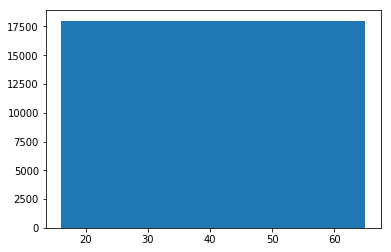

Final Training Size: (180000, 11)


In [5]:
# Create the new resampled dataframe.
df_train_resample = resample(df_train[(df_train.age>15) & (df_train.age<=20)], n_samples=18000)

# Concat with the remaining age groups.
for i in range(20, 61, 5):
    df_train_resample = pd.concat([df_train_resample, 
                                   resample(df_train[(df_train.age>i) & (df_train.age<=i+5)], n_samples=18000)])

# Shuffle and reset indices.
df_train_resample = df_train_resample.sample(frac=1).reset_index(drop=True)

plt.hist(df_train_resample.age, bins=10)
plt.show()

print('Final Training Size:', df_train_resample.shape)

In [10]:
# Everything all set?
df_train_resample.head()

dob  photo_yr  age                                          file_path  \
0  1992      2008   16    /data/wiki_crop/26/16720526_1991-03-27_2008.jpg   
1  1964      2009   45  /data/imdb_crop/08/nm0004908_rm1420790784_1963...   
2  1966      1995   29  /data/imdb_crop/66/nm0000566_rm2991823104_1965...   
3  1976      2001   25  /data/imdb_crop/65/nm0224565_rm2122026752_1975...   
4  1950      2010   60  /data/imdb_crop/13/nm0000313_rm510690304_1949-...   

   gender                    name  \
0     0.0        [Chloe Marshall]   
1     0.0            [Edie Falco]   
2     0.0          [Julia Ormond]   
3     1.0  [Chris Diamantopoulos]   
4     1.0          [Jeff Bridges]   

                                            face_loc  face_score  second_face  \
0                        [173.6, 45.6, 230.4, 102.4]    5.349818          NaN   
1  [120.860839093, 38.2255122166, 187.807561083, ...    0.890518          NaN   
2                      [206.15, 54.15, 273.6, 121.6]    0.897098          NaN   
3  [455.431948115, 223.928880208, 531.599637418, ...    3.613480          NaN   
4  [68.8074489264, 85.856311158, 221.635209011, 2...    3.944899          NaN   

   x_dim  y_dim  
0    105    105  
1    122    122  
2    123    123  
3    139    138  
4    277    277

## Image Preprocessing

For our model, we'll have to resize all our images and put them into a numpy array. We've gotten rid of all the bad images by using the face_score and removing small images. It would be nice to process with as large a standard image size as possible, without having to upsize too many images, as doing so may have adverse effects on our CNN. 

Here I'll create preprocessing functions and run them on a sample of the data, but we'll save running them in full until we're doing the modeling.

In [6]:
# Create our file array, load the images and resize them with cv2.

def process_images(df, final_shape=(150, 150)):
    # Set up array.
    X = []
    
    # Get each filename, read, resize, and append to X.
    for file in df.file_path:
        X.append(cv2.resize(cv2.imread(file), final_shape))
    
    # Normalize the array as a float.
    X = np.asarray(X)/255.
    
    # Y is just the age from the df.
    Y = np.array(df.age)
    
    return X, Y

In [7]:
df_sample = df_train_resample[:500]
X_sample, Y_sample = process_images(df_sample)
print('Final shape:', X_sample.shape, Y_sample.shape)

Final shape: (500, 150, 150, 3) (500,)


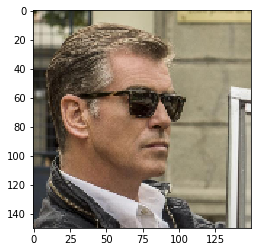

Age: 60


In [8]:
# Let's make sure it worked.
plt.imshow(X_sample[200][:,:,::-1])
plt.show()
print('Age:', Y_sample[200])

Great! I wonder if our lower resolution photos will do significantly worse...

# Modeling

We're going to need a function to break our data up into batches and run it through the model.

In [24]:
# The function will take our df and split it into batches of desired size.
# The result is meant to be fed item-wise into process_images() function.
# Example: 
#    for batch in get_batches(df):
#        model.fit(process_images(batch), 
#                  ...)
#
# This prevents processed images from taking over memory.

def get_batches(df, batch_size=10000):
    if len(df) < batch_size:
        return [df]
    
    n_batches = len(df) // batch_size

    # If batches fit exactly into the size of df.
    if len(df) % batch_size == 0:
        return [df[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]
    
    # If there is a remainder.
    else:
        return [df[i*batch_size:min((i+1)*batch_size, len(df))] for i in range(n_batches+1)]

In [15]:
# Each item in this list is a dataframe ready for process_images().
len(get_batches(df_train_resample, 8000))

23

In [16]:
#Test our functions.
for batch in get_batches(df_sample, 500):
    X, Y = process_images(batch)

print(X.shape, Y.shape)

(500, 150, 150, 3) (500,)


Because of this makeshift method for processing images on-demand, we're going to have to run one epoch at a time. Let's make one more function at actually fit the model.

In [23]:
# Fit model using get_batches() and process_images().
#
# Inputs are: 
#
#      model -- model to train
#      df_train -- df to train, ready to be passed into get_batches.
#      df_val -- df to validate, ready to be passed into get_batches or process_images.
#      epochs -- number of total epochs to run.
#      df_batch_size -- batch size to pass into get_batches. Larger values take more memory but reprocess fewer times.
#      model_batch_size -- batch size passed into model.fit.
#      image_size -- image size passed into process_images.
#
#

def fit_model(model, df_train, df_val, epochs=10, df_batch_size=10000, model_batch_size=128, image_size=(150, 150)):
    
    print('Training on {} examples.'.format(len(df_train)))
    print('Validating on {} examples.'.format(len(df_val)))
    
    # We have to run epochs one at a time -- each epoch we'll evaluate the val set.
    for i in range(epochs):
        
        print('\nStarting Epoch {} of {}.'.format(i+1, epochs))
        
        # In each epoch, we'll run the model on each of the batches.
        for batch in get_batches(df_train, df_batch_size):
            X, Y = process_images(batch, image_size)
            model.fit(X, Y,
                      batch_size=model_batch_size,
                      epochs=1,
                      verbose=1)

        X_val, Y_val = process_images(df_val, image_size)
        score = model.evaluate(X_val, Y_val, verbose=1)
    
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score

## A Quick Model

Let's make a quick neural net just to get us started.

In [57]:
quick_model = Sequential()

quick_model.add(Flatten(input_shape=(150, 150, 3)))
quick_model.add(Dense(128, activation='relu'))
quick_model.add(Dropout(.1))
quick_model.add(Dense(1, activation='relu'))

quick_model.summary()

quick_model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8640128   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 8,640,257
Trainable params: 8,640,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
score = fit_model(quick_model, 
                  df_sample, 
                  df_sample, 
                  epochs=3, 
                  df_batch_size=200)

Alright! We've got everything queued up. Now we can start to process a large amount of data, preferably on a machine better than my laptop.

## Dense Neural Network

Before we try out a CNN for this dataset, let's see if we can do anything with a standard densely connected NN.

In [ ]:
# In case you've already saved the model
dense_model = load_model('dense_model.h5')

In [53]:
# Build the densely connected neural net.
dense_model = Sequential()

dense_model.add(Flatten(input_shape=(150, 150, 3)))
dense_model.add(Dense(256, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(64, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(1, activation='relu'))

dense_model.summary()

dense_model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

In [ ]:
score = fit_model(dense_model, 
                  df_train_resample, 
                  df_val, 
                  epochs=3, 
                  df_batch_size=10000)

In [12]:
def plot_val_train(model, X_val, Y_val, X_train, Y_train):
    
    # Predict and fit validation data
    Y_pred_val = model.predict(X_val)
    fit_val = np.polyfit(Y_val, Y_pred_val, deg=1)
    
    # Predit and fit training data
    Y_pred_train = model.predict(X_train)
    fit_train = np.polyfit(Y_train, Y_pred_train, deg=1)
    
    # Make plot
    plt.figure(figsize=(10,4))
    
    # Plot Validation Data
    plt.subplot(1, 2, 1)
    plt.scatter(Y_val, Y_pred_val)
    plt.plot(Y_val, Y_val * fit_val[0] + fit_val[1], color='red')
    plt.plot(Y_val, Y_val, color='yellow')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Validation Data')
    
    plt.subplot(1, 2, 2)
    plt.scatter(Y_train, Y_pred_train)
    plt.plot(Y_train, Y_train * fit_train[0] + fit_train[1], color='red')
    plt.plot(Y_train, Y_train, color='yellow')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Training Data')    
    
    plt.show()

In [13]:
X_val, Y_val = process_images(df_val)
X_train_10k, Y_train_10k = process_images(df_train_resample[:10000])

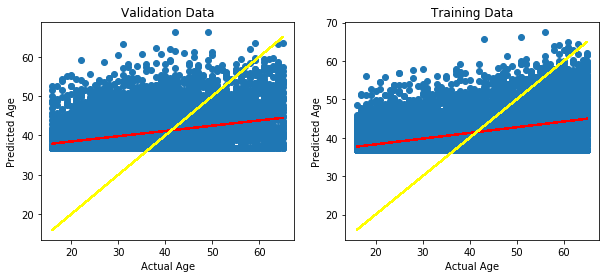

In [99]:
plot_val_train(dense_model, X_val, Y_val, X_train_10k, Y_train_10k)

In [100]:
dense_model.save('dense_model.h5')

## Convolutional Neural Network

Okay -- that model is doing pretty much nothing... Let's try CNN.

In [ ]:
# In case you have a saved version.
cnn_model = load_model('cnn_model.h5')

In [101]:
cnn_model = Sequential()

# First convolutional layer, note the specification of shape

cnn_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1, activation='linear'))

cnn_model.summary()

cnn_model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               43655296  
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
__________

In [ ]:
score = fit_model(cnn_model, 
                  df_train_resample, 
                  df_val, 
                  epochs=3, 
                  df_batch_size=20000)

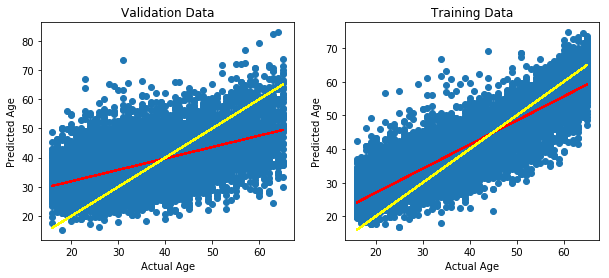

In [23]:
plot_val_train(cnn_model, X_val, Y_val, X_train_10k, Y_train_10k)

In [24]:
cnn_model.save('cnn_model.h5')

# Unsupervised Learning

Build an autoencoder, plug results into sklearn clustering algorithms.

In [14]:
auto_model = load_model('auto_model.h5')

In [22]:
# The autoencoder doesn't use X and Y, so we need to modify our fit_model function.

def fit_auto(model, df_train, epochs=10, df_batch_size=10000, model_batch_size=128, image_size=(150, 150)):
    
    print('Training on {} examples.'.format(len(df_train)))
    
    # We have to run epochs one at a time -- each epoch we'll evaluate the val set.
    for i in range(epochs):
        
        print('\nStarting Epoch {} of {}.'.format(i+1, epochs))
        
        # In each epoch, we'll run the model on each of the batches.
        for batch in get_batches(df_train, df_batch_size):
            X, Y = process_images(batch, image_size)
            model.fit(X, X,
                      batch_size=model_batch_size,
                      epochs=1,
                      verbose=1)

    score = model.evaluate(X, X, verbose=1)
    
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score

In [28]:
auto_model = Sequential()

# First convolutional layer, note the specification of shape

auto_model.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               input_shape=(150, 150, 3),
               padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
auto_model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', padding='same'))
#auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
auto_model.add(Conv2D(12, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Encoding finished, starting decoding

auto_model.add(Conv2D(12, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
#auto_model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', padding='same'))
#auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
auto_model.add(UpSampling2D((2, 2)))
auto_model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid'))

auto_model.summary()

auto_model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 75, 75, 24)        6936      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 12)        2604      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 38, 38, 12)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 38, 38, 12)        1308      
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 76, 76, 12)        0         
__________

In [29]:
# We'll use the original training set 

score = fit_auto(auto_model,
                 df_train,
                 epochs=1,
                 df_batch_size=20000)

Training on 175857 examples.

Starting Epoch 1 of 1.
Epoch 1/1
20000/20000 [==============================] - 87s - loss: 0.5677 - acc: 0.0139    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5141 - acc: 0.0153    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5085 - acc: 0.0150    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5064 - acc: 0.0151    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5035 - acc: 0.0142    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5023 - acc: 0.0150    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5021 - acc: 0.0147    
Epoch 1/1
20000/20000 [==============================] - 84s - loss: 0.5018 - acc: 0.0145    
Epoch 1/1
15857/15857 [==============================] - 31s    
Test loss: 0.501227964111
Test accuracy: 0.0147246739889


In [31]:
auto_model.save('auto_model.h5')

Before autoencoding:


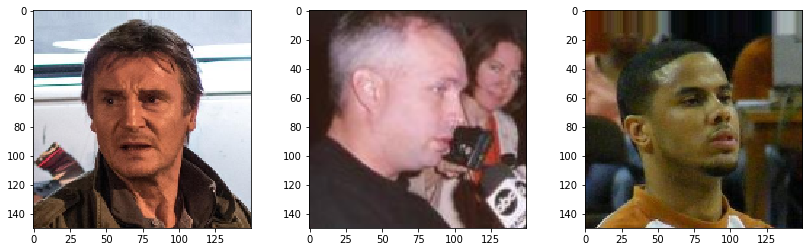

After decoding:


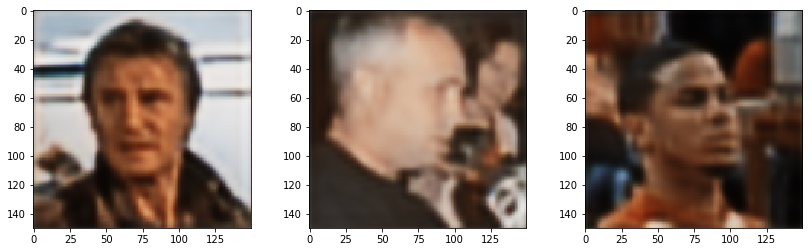

In [30]:
im_decoded = auto_model.predict(X_sample[:3])

print('Before autoencoding:')
plot_three(X_sample[:3])
print('After decoding:')
plot_three(im_decoded[:3])

## Building an Attention Model

We'll grab the output from the last convolutional layer in the model and use that to determine where the model is paying the most attention.

In [32]:
# Create a function to run the first 4 layers of the auto_model.
get_encoded = K.function([auto_model.layers[0].input],
                     [auto_model.layers[4].output])

# Run that function on the sample set.
encoded_sample = get_encoded([X_sample])[0]

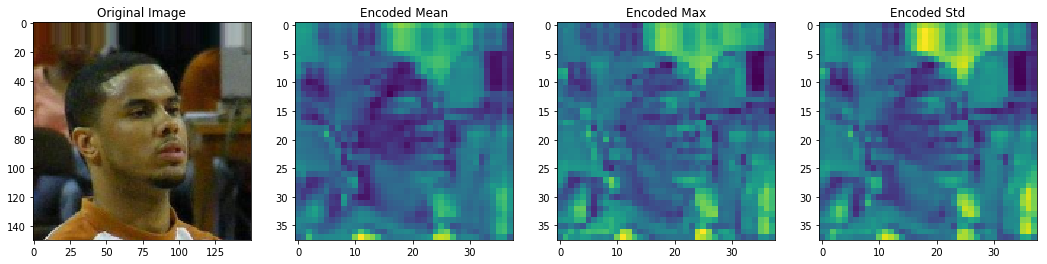

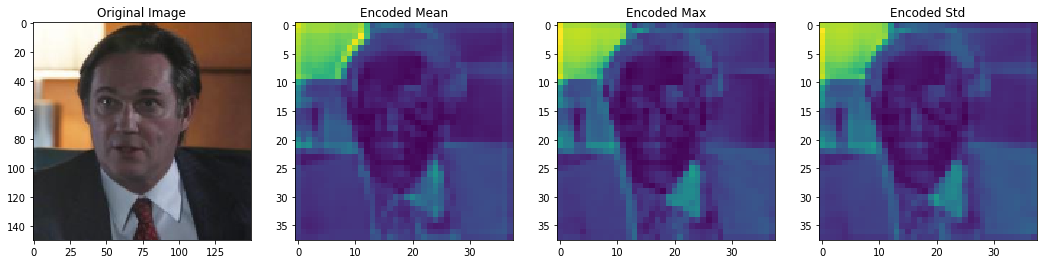

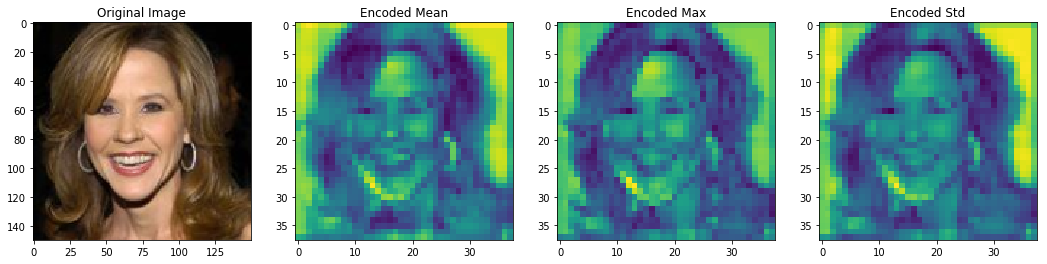

In [33]:
# Let's see what different evaluation metrics (mean, max, std) look like on the internal model filters.

for n_image in [2, 4, 6]:
    plt.figure(figsize=(18,4))

    plt.subplot(1,4,1)
    plt.imshow(X_sample[n_image][:,:,::-1])
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(encoded_sample[n_image].mean(axis=2))
    plt.title('Encoded Mean')

    plt.subplot(1,4,3)
    plt.imshow(encoded_sample[n_image].max(axis=2))
    plt.title('Encoded Max')

    plt.subplot(1,4,4)
    plt.imshow(encoded_sample[n_image].std(axis=2))
    plt.title('Encoded Std')

    plt.show()

These are all pretty similar. The standard method for processing a convolutional layer is to take the max() of the filters. Let's stick with convention and use that method for our attention map as well.

In [34]:
# Inputs are:
#     model: a neural network with a convolutional layer
#     last_conv_layer: the numeric index of the final convolutional layer in the model
#     X_data: the data you want converted

def pool_conv_layer(model, X_data, last_conv_layer=4):
    # Run the model up until the last convolutional layer.
    get_encoded = K.function([model.layers[0].input],
                             [model.layers[last_conv_layer].output])
    encoded_array = get_encoded([X_data])[0]
    pooled_array = encoded_array.max(axis=3)
    return pooled_array

def plot_with_attention(model, X_data, n_images, last_conv_layer=4):
    X_to_plot = X_data[np.random.choice(range(len(X_data)), n_images, replace=False)]
    pooled_array = pool_conv_layer(model, X_to_plot, last_conv_layer)
    
    plt.figure(figsize=(10, 4*n_images))
    for i in range(n_images):
        plt.subplot(n_images, 2, 2*i+1)
        plt.imshow(X_to_plot[i][:,:,::-1])
        plt.subplot(n_images, 2, 2*i+2)
        plt.imshow(cv2.resize(pooled_array[i], (X_to_plot.shape[1], X_to_plot.shape[2])))
                   
    plt.show()

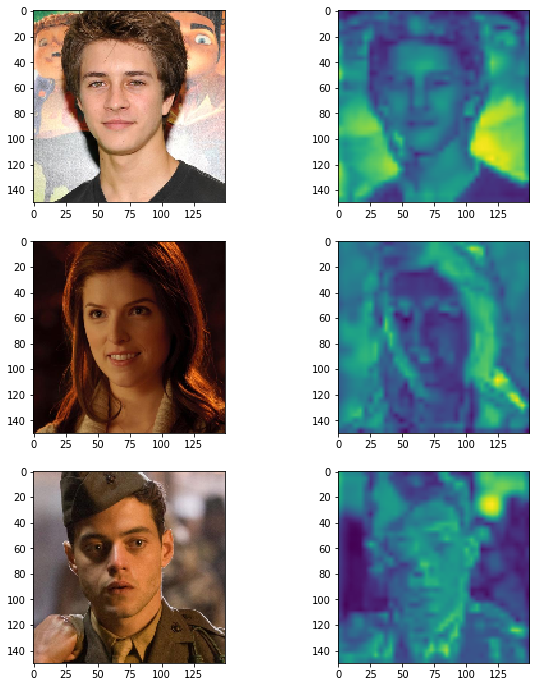

In [35]:
plot_with_attention(auto_model, X_sample, 3)

The image on the right is the max of the filters of the decoded image. Bright spots are where the model is activated the most.

## Clustering With Attention

The full images are too big and complicated to cluster effectively. Instead, we'll use the encoded versions and see what features our clustering algorithm takes into account in making its decisions. We could use the full 8-layer images, but let's try with just the max pooling method we've established.

In [10]:
X_encoded = np.load('X_encoded.npy')

In [ ]:
# We'll flatten the dimensions 
X_encoded = []
i=0
for batch in get_batches(df_train, batch_size=1000):
    i+=1
    print('Running batch... {}'.format(i*len(batch)))
    X_encoded.append(pool_conv_layer(auto_model, process_images(batch)[0]))
    
X_encoded = np.concatenate(X_encoded)

Running batch... 1000
Running batch... 2000
Running batch... 3000
Running batch... 4000
Running batch... 5000
Running batch... 6000
Running batch... 7000
Running batch... 8000
Running batch... 9000
Running batch... 10000
Running batch... 11000
Running batch... 12000
Running batch... 13000
Running batch... 14000
Running batch... 15000
Running batch... 16000
Running batch... 17000
Running batch... 18000
Running batch... 19000
Running batch... 20000
Running batch... 21000
Running batch... 22000
Running batch... 23000
Running batch... 24000
Running batch... 25000
Running batch... 26000
Running batch... 27000


In [42]:
np.save('X_encoded.npy', X_encoded)

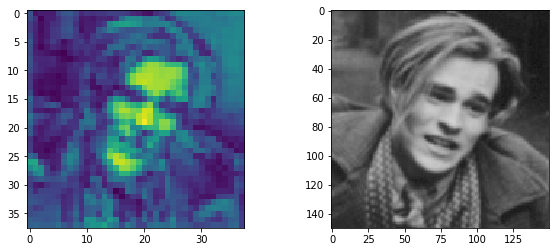

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(X_encoded[1])
plt.subplot(122)
plt.imshow(process_images(df_train.iloc[1:2, :])[0][0][:,:,::-1])
plt.show()

In [44]:
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2])
X_encoded_reshape.shape

(175857, 1444)

In [ ]:
km = KMeans(n_clusters = 10)
km.fit(X_encoded_reshape)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
for i in range(10):
    print('Items in cluster {}:'.format(i), (km.labels_==i).sum())

Items in cluster 0: 13022
Items in cluster 1: 21336
Items in cluster 2: 5860
Items in cluster 3: 6445
Items in cluster 4: 8418
Items in cluster 5: 22762
Items in cluster 6: 37062
Items in cluster 7: 12771
Items in cluster 8: 28019
Items in cluster 9: 20162


Cluster 0: 13022 Elements


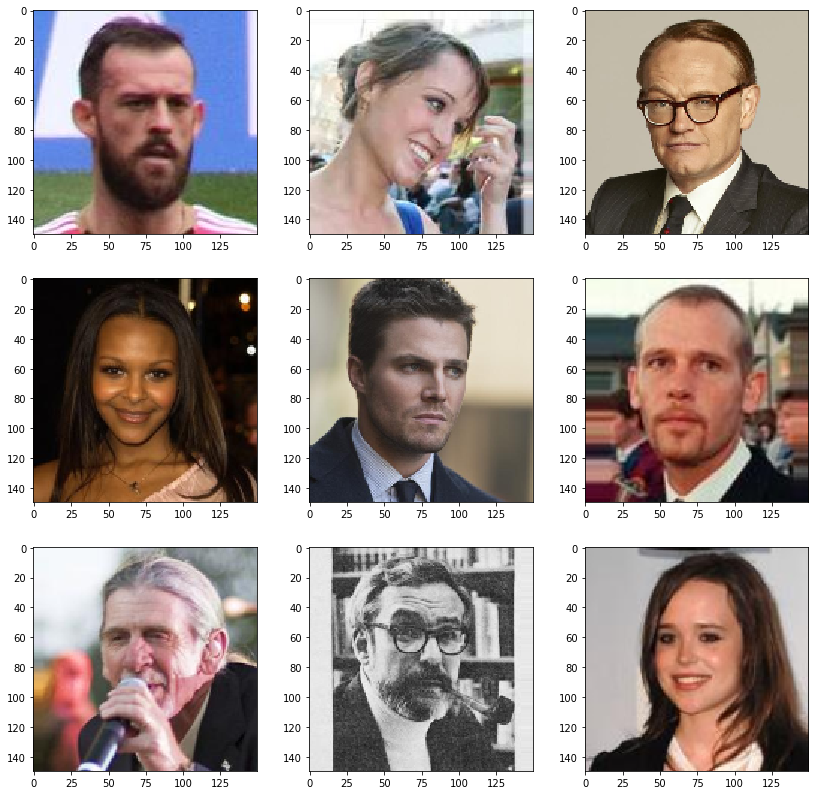

Cluster 1: 21336 Elements


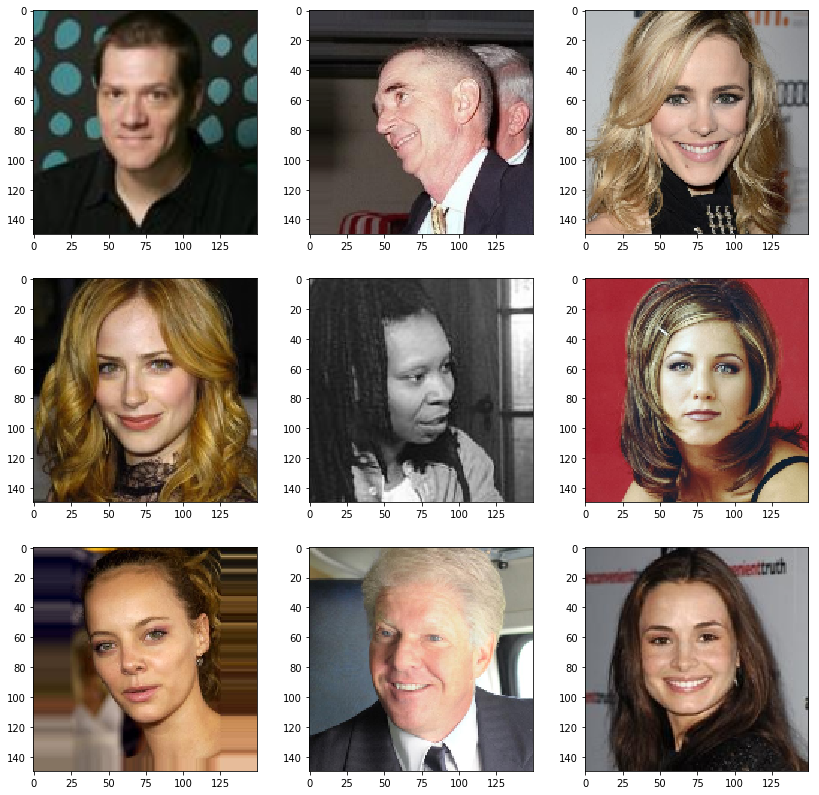

Cluster 2: 5860 Elements


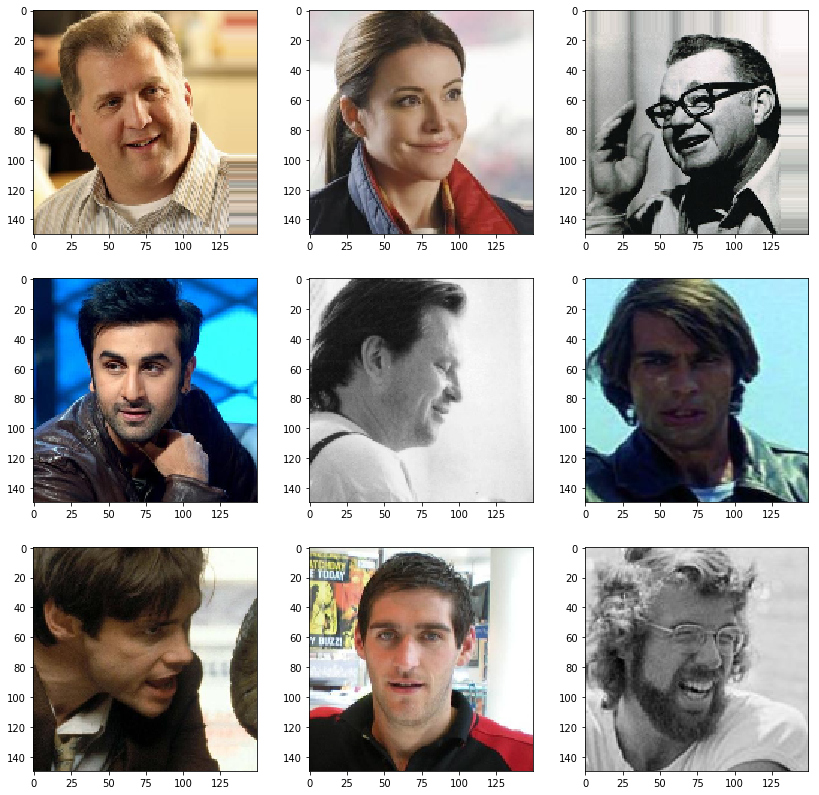

Cluster 3: 6445 Elements


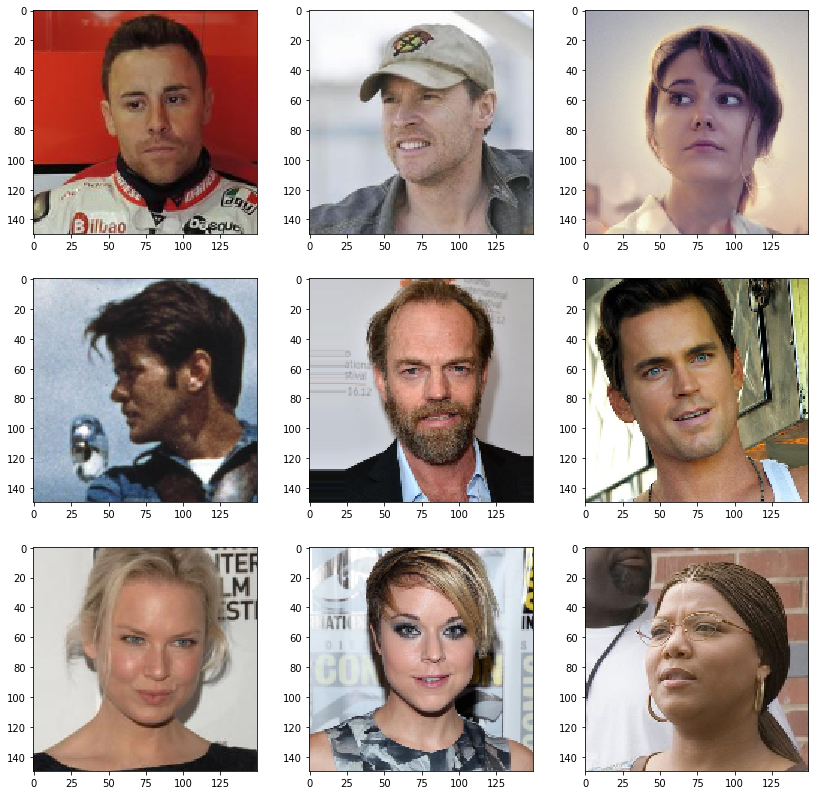

Cluster 4: 8418 Elements


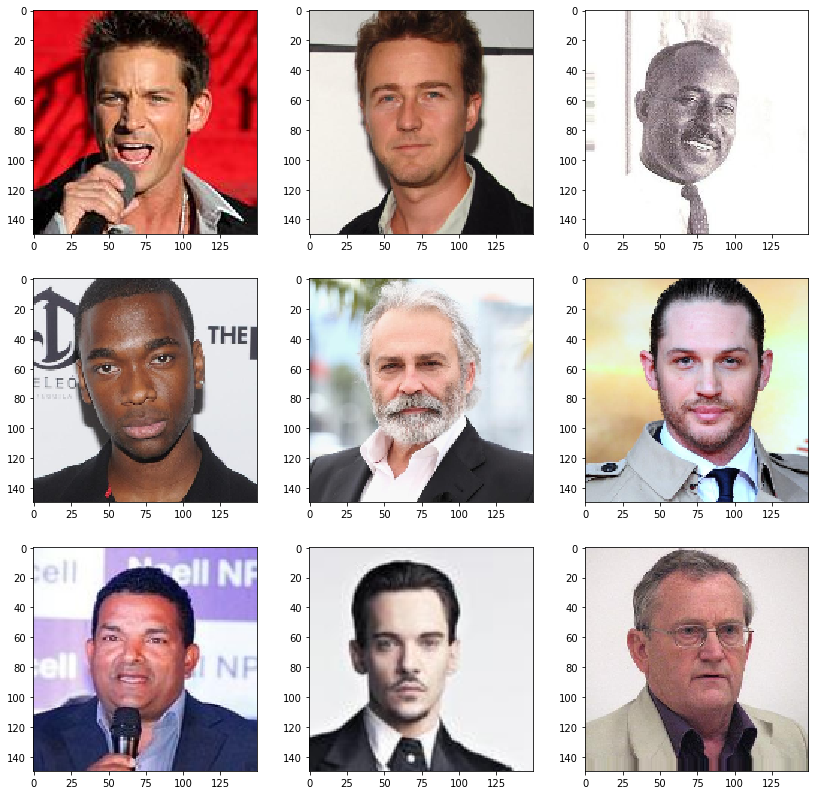

Cluster 5: 22762 Elements


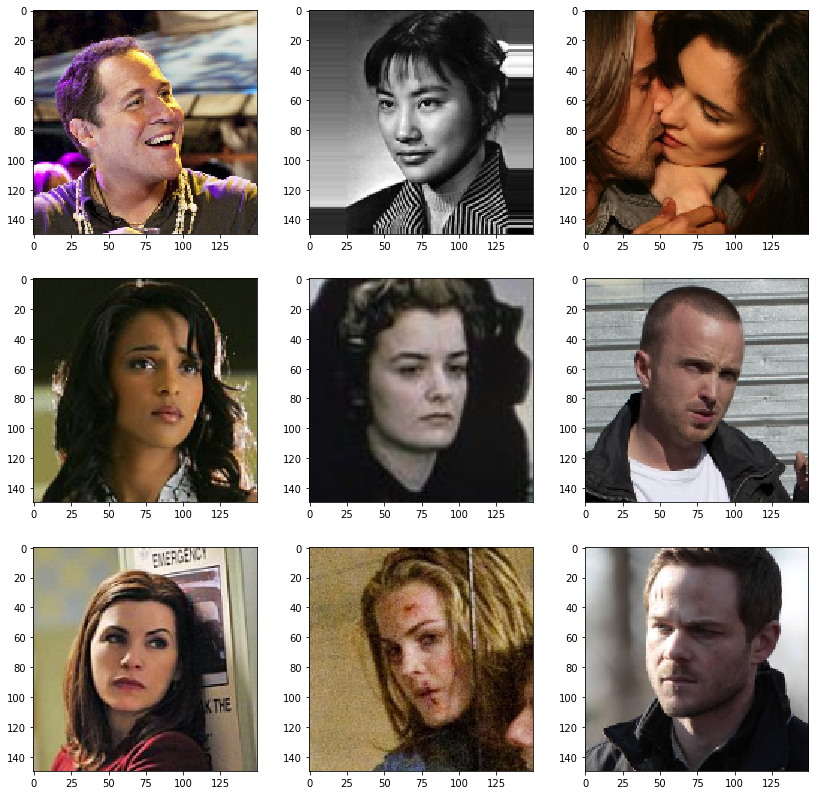

Cluster 6: 37062 Elements


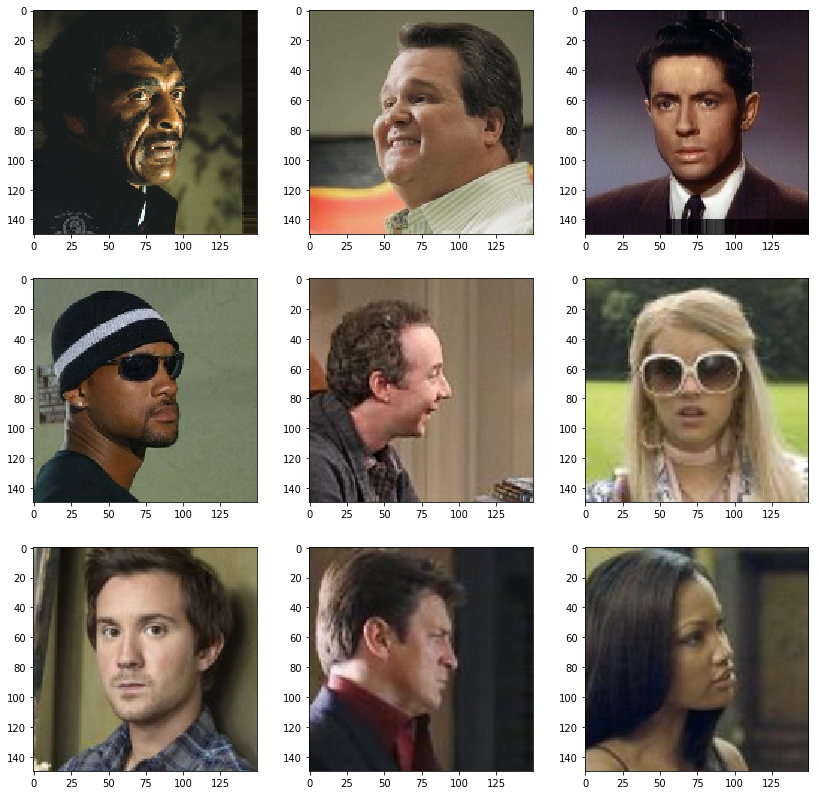

Cluster 7: 12771 Elements


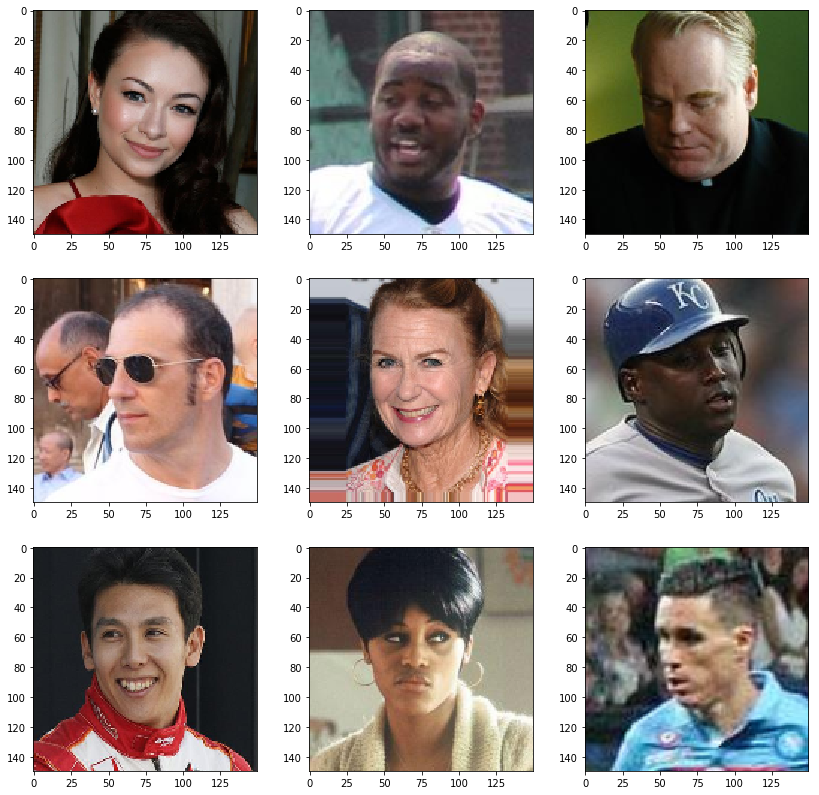

Cluster 8: 28019 Elements


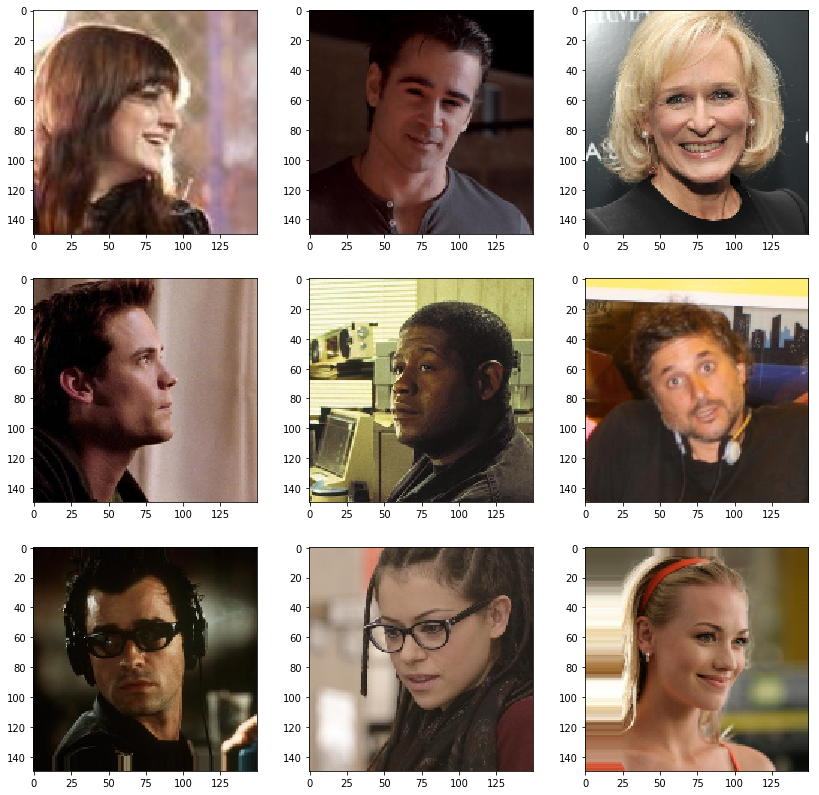

Cluster 9: 20162 Elements


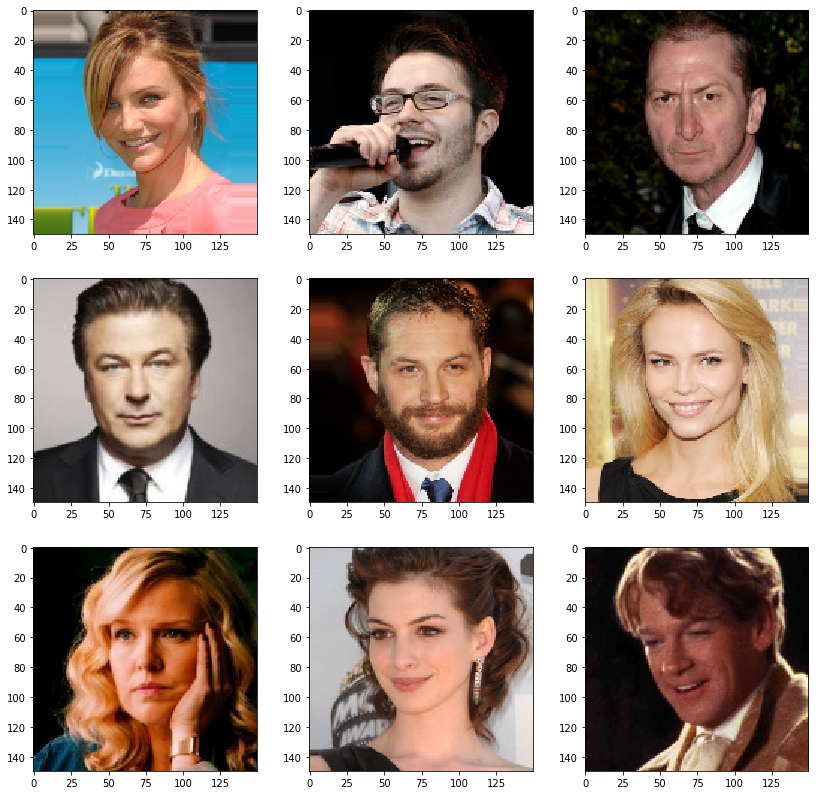

In [47]:
# Displot nine images from each cluster.
for i in range(10):
    print('Cluster {}: {} Elements'.format(i, (km.labels_==i).sum()))
    plot_nine(process_images(df_train.iloc[np.random.choice(np.where(km.labels_==i)[0], 9, replace=False), :])[0])

In [48]:
# Show the images from a single cluster with their encoded version.
plot_with_attention(auto_model, 5, X_val[np.where(km.labels_==2)], 3)

NameError: name 'X_val' is not defined